# Analyzing experimental data

*Some imports*

In [2]:
import numpy as np
import scipy
import typing
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

In [ ]:
!ls data

Spiketimes_Ntsr1Cre_2020_0003_s02_e05.npy  Stiminfo_PVCre_2021_0012_s06_e14.csv
Spiketimes_Ntsr1Cre_2020_0003_s02_e10.npy  res.pkl
Spiketimes_PVCre_2021_0012_s06_e14.npy	   simple_cell_center_fp
Stiminfo_Ntsr1Cre_2020_0003_s02_e05.npy    simple_cell_random_fp
Stiminfo_Ntsr1Cre_2020_0003_s02_e10.npy


## Loading

##### *Load squares data*

In [7]:

squares_stim = np.load(open('data/Stiminfo_Ntsr1Cre_2020_0003_s02_e10.npy', 'rb'), allow_pickle=True).item()
squares_spikes = np.load(open('data/Spiketimes_Ntsr1Cre_2020_0003_s02_e10.npy', 'rb'), allow_pickle=True).item()

In [9]:
squares_stim['ename'], squares_stim.keys()

('AsparseNoise5_60deg',
 dict_keys(['ename', 'area', 'probename', 'electrode_spacing', 'monitor_offset', 'stimtimes', 'stimvals', 'opto', 'optotimes', 'ivs', 'run_spdthr', 'run_minon', 'runperiods']))

In [ ]:
squares_stim['ivs'].keys()

dict_keys(['grat_x_position', 'grat_y_position', 'grat_contrast'])

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

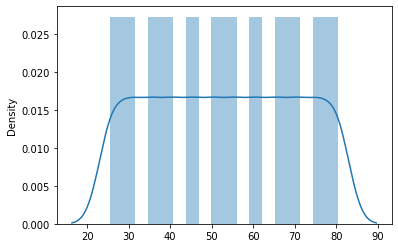

In [10]:
sns.distplot(squares_stim['ivs']['grat_x_position'])

In [11]:
squares_stim['ivs']['grat_x_position'].min(), squares_stim['ivs']['grat_x_position'].max()

(25.4911, 80.5089)

In [12]:

squares_stim['ivs']['grat_y_position'].min(), squares_stim['ivs']['grat_y_position'].max()

(-27.5089, 27.5089)

In [13]:
squares_spikes['units']

array([  4,   8,  11,  14,  17,  20,  26,  29,  33,  34,  35,  36,  37,
        41,  44,  45,  46,  48,  51,  58,  59,  67,  72,  77,  82,  87,
        93,  96, 101, 104, 112, 116, 120, 128, 129, 140, 141, 142, 144,
       145])

/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

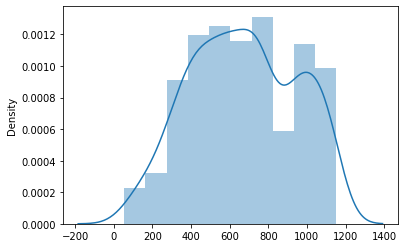

In [14]:
sns.distplot(squares_spikes['spiketimes'][0])

##### *Load gratings data*

In [18]:
gratings_stim = np.load(open('data/Stiminfo_Ntsr1Cre_2020_0003_s02_e05.npy', 'rb'), allow_pickle=True).item()
gratings_spikes = np.load(open('data/Spiketimes_Ntsr1Cre_2020_0003_s02_e05.npy', 'rb'), allow_pickle=True).item()

In [19]:
gratings_stim.keys()

dict_keys(['ename', 'area', 'probename', 'electrode_spacing', 'monitor_offset', 'stimtimes', 'stimvals', 'optotimes', 'opto', 'optofreq', 'ivs', 'run_spdthr', 'run_minon', 'runperiods'])

In [20]:
gratings_stim['ename']

'oriTun12_opto'

In [ ]:
gratings_stim['ivs'].keys()

dict_keys(['grat_height', 'opto', 'optofreq'])

In [ ]:
gratings_spikes['RFpars'][0]

array([ 9.55191999, -3.82510311,  1.18950616,  1.        ,  3.35761066,
        4.65747346,  0.05402836])

## Pre-processing squares data

*Turn squares data into a better format*

`{'squares': (x, y, c), 'firing_rates': [fr1, fr2, ...]}`

In [ ]:
squares_stim['stimtimes'][0], squares_stim['stimtimes'][-1], squares_spikes['spiketimes'][0][0], squares_spikes['spiketimes'][0][-1]

(array([1.512 , 1.7124]),
 array([1155.5455, 1155.7459]),
 54.692066,
 1152.682366)

In [21]:
get_firing_rates = lambda i: ((squares_stim['stimtimes'][:, 0].reshape((-1, 1)) <= squares_spikes['spiketimes'][i]) * (squares_spikes['spiketimes'][i] < squares_stim['stimtimes'][:, 1].reshape((-1, 1)))).sum(axis=1) / (squares_stim['stimtimes'][:, 1] - squares_stim['stimtimes'][:, 0])

In [22]:
N_UNITS = squares_spikes['spiketimes'].shape[0]
N_EXPS = squares_stim['stimtimes'].shape[0]
N_UNITS, N_EXPS

(40, 5760)

In [23]:
firing_rates = np.array([get_firing_rates(i) for i in range(N_UNITS)])

In [24]:
stim_data = np.array([((squares_stim['ivs']['grat_x_position'][i] - 25) * 100 / 60, 100 * (squares_stim['ivs']['grat_y_position'][i] / 55) + 50, round(squares_stim['ivs']['grat_contrast'][i])) for i in range(len(squares_stim['ivs']['grat_x_position']))])

In [25]:
squares_data = {'squares': stim_data, 'firing_rates': firing_rates}
firing_rates.shape, stim_data.shape

((40, 5760), (5760, 3))

In [26]:
fields_plus = [np.zeros((100, 100)) for i in range(N_UNITS)]
fields_minus = [np.zeros((100, 100)) for i in range(N_UNITS)]
r_coord = lambda x: min(max(round(x), 0), 99)

for i in range(N_EXPS):
    for j in range(N_UNITS):
        if squares_data['squares'][i, 2] >= 0:
            fields_plus[j][r_coord(squares_data['squares'][i, 0]), r_coord(squares_data['squares'][i, 1])] += squares_data['firing_rates'][j, i]
        else:
            fields_minus[j][r_coord(squares_data['squares'][i, 0]), r_coord(squares_data['squares'][i, 1])] += squares_data['firing_rates'][j, i]

In [ ]:
for i in range(N_UNITS):
    fields_plus[i] = scipy.ndimage.gaussian_filter(fields_plus[i], sigma=6)
    fields_minus[i] = scipy.ndimage.gaussian_filter(fields_minus[i], sigma=6)

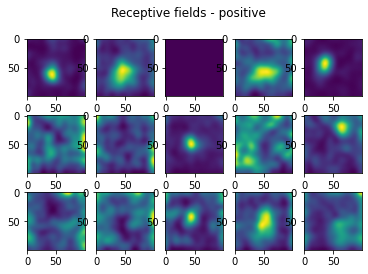

In [ ]:
fig, ax = plt.subplots(3, 5)
ax = ax.flatten()
# set title
fig.suptitle('Receptive fields - positive')
for i in range(len(ax)):
    ax[i].imshow(fields_plus[i])

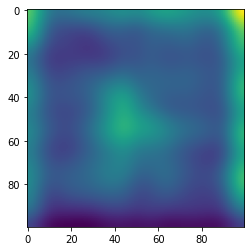

In [ ]:
plt.imshow(np.array(fields_plus).mean(axis=0))

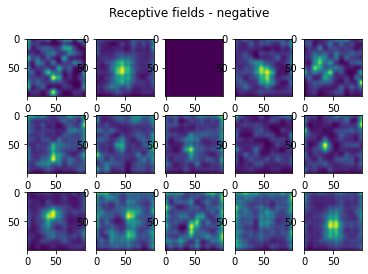

In [ ]:
fig, ax = plt.subplots(3, 5)
ax = ax.flatten()
# set title
fig.suptitle('Receptive fields - negative')
for i in range(len(ax)):
    ax[i].imshow(fields_minus[i])

## Finding centers of the receptive fields

In [ ]:
from scipy import signal

def gkern(kernlen=100, std=5, x=0, y=0):
    """Returns a 2D Gaussian kernel array."""
    if not x and not y:
        gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
        gkern2d = np.outer(gkern1d, gkern1d)
        return gkern2d
    else:
        return np.roll(gkern(kernlen, std, 0, 0), (x - 50, y - 50))


def find_center(field) -> typing.Tuple[typing.Tuple[int, int], float]:
    """
    Find the center of the field and return it and the score
    """
    center = np.unravel_index(np.argmax(scipy.ndimage.gaussian_filter(field, sigma=7)), field.shape)
    score = np.sum(field * gkern(x=center[0], y=center[1])) / field.mean()
    return center, score

In [ ]:
centers_pos = [find_center(fields_plus[i]) for i in range(N_UNITS)]
centers_neg = [find_center(fields_minus[i]) for i in range(N_UNITS)]

/tmp/ipykernel_4092185/2956312832.py:18: RuntimeWarning: invalid value encountered in double_scalars
  score = np.sum(field * gkern(x=center[0], y=center[1])) / field.mean()


/usr/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


12

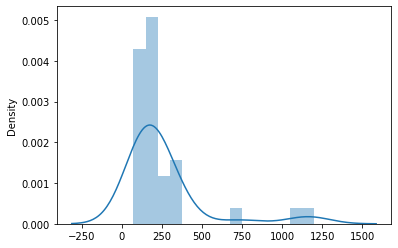

In [ ]:
sns.distplot([centers_pos[i][1] for i in range(N_UNITS)])
tuning_threshold = 200
sum(centers_pos[i][1] > tuning_threshold for i in range(N_UNITS))

In [ ]:
tuned_units = [i for i in range(N_UNITS) if centers_pos[i][1] > tuning_threshold]

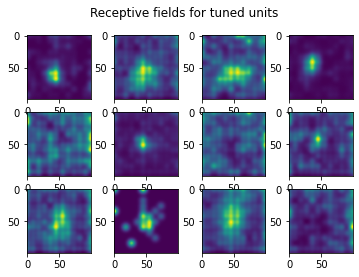

In [ ]:
fig, ax = plt.subplots(3, 4)
ax = ax.flatten()
fig.suptitle('Receptive fields for tuned units')
for i in range(min(len(tuned_units), len(ax))):
    ax[i].imshow(fields_plus[tuned_units[i]])


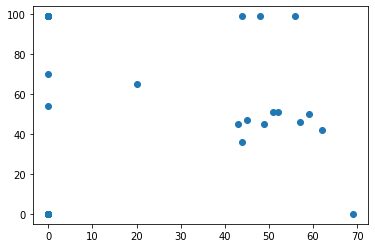

In [ ]:
centers_pos_np = np.array([c for c, _ in centers_pos])
plt.scatter(centers_pos_np[:, 0], centers_pos_np[:, 1])

## Preprocessing grating data